In [1]:
#!pip install zeus-mcmc
#python -m pip install drawdata
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
import zeus
import pandas as pd
from drawdata import ScatterWidget

In [2]:
𝘄𝗶𝗱𝗴𝗲𝘁 = 𝗦𝗰𝗮𝘁𝘁𝗲𝗿𝗪𝗶𝗱𝗴𝗲𝘁() 
𝘄𝗶𝗱𝗴𝗲𝘁 

ScatterWidget()

In [408]:
W = widget.data_as_pandas
W['sigma'] = np.random.uniform(0, 100, size=len(W))
W

,x,y,color,label,sigma
0,4.108332,9.448315,#1f77b4,a,38.213573
1,5.342088,11.346042,#1f77b4,a,69.776771
2,8.987939,21.248803,#1f77b4,a,98.094068
3,8.486389,29.819405,#1f77b4,a,56.555865
4,4.705863,43.582789,#1f77b4,a,10.818944
...,...,...,...,...,...
333,802.544771,70.517262,#1f77b4,a,59.941258
334,803.622397,70.309350,#1f77b4,a,98.240285
335,800.837067,70.060420,#1f77b4,a,80.947828
336,802.624993,65.278243,#1f77b4,a,78.347125


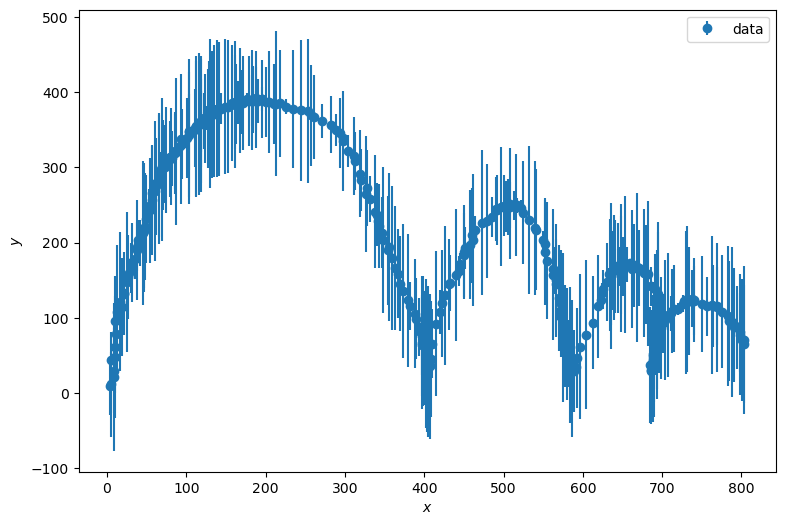

In [409]:
plt.figure(figsize=(9,6))
plt.errorbar(W['x'], W['y'], yerr=W['sigma'], fmt="o", label='data')
#plt.plot(W['x'], straight_line(W['x'], m_true, c_true), '-', lw=2, label='model')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

## Funcion parabolica

$$f(x)  = \alpha x^{2} + \beta x + \zeta$$

In [410]:
def logprior(theta):
    ''' The natural logarithm of the prior probability. '''
    lp = 0.
    # unpack the model parameters from the tuple
    alpha, beta, zeta = theta

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    if (-10 < alpha < 10) or (-10 < beta < 10) or (-10 < zeta <10):
        return lp
    else:
        return -np.inf

# define the model function
def parabola(x, alpha, beta,zeta):
    ''' Parabola: y = ax^2 + bx + c '''
    return (alpha*(x**2)) + (beta*x) + zeta


def loglike(theta, y, sigma, x):
    '''The natural logarithm of the likelihood.'''

    # unpack the model parameters
    alpha, beta, zeta = theta

    # evaluate the model
    model = parabola(x, alpha, beta,zeta)

    # return the log likelihood
    return -0.5 * np.sum(((model - y)/sigma)**2)

def logpost(theta, y, sigma, x):
    '''The natural logarithm of the posterior.'''

    return logprior(theta) + loglike(theta, y, sigma, x)


In [411]:
ndim = 3 # Number of parameters/dimensions (e.g. m and c)
nwalkers = 10 # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 5000 # Number of steps/iterations.

start = 0.01 * np.random.randn(nwalkers, ndim) # Initial positions of the walkers.

sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, args=[np.array(W['y']), np.array(W['sigma']), np.array(W['x'])]) # Initialise the sampler
sampler.run_mcmc(start, nsteps) # Run sampling
sampler.summary # Print summary diagnostics

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 5000/5000 [00:19<00:00, 257.34it/s]
Summary
-------
Number of Generations: 5000
Number of Parameters: 3
Number of Walkers: 10
Number of Tuning Generations: 44
Scale Factor: 0.298811
Mean Integrated Autocorrelation Time: 4.9
Effective Sample Size: 10207.53
Number of Log Probability Evaluations: 323758
Effective Samples per Log Probability Evaluation: 0.031528


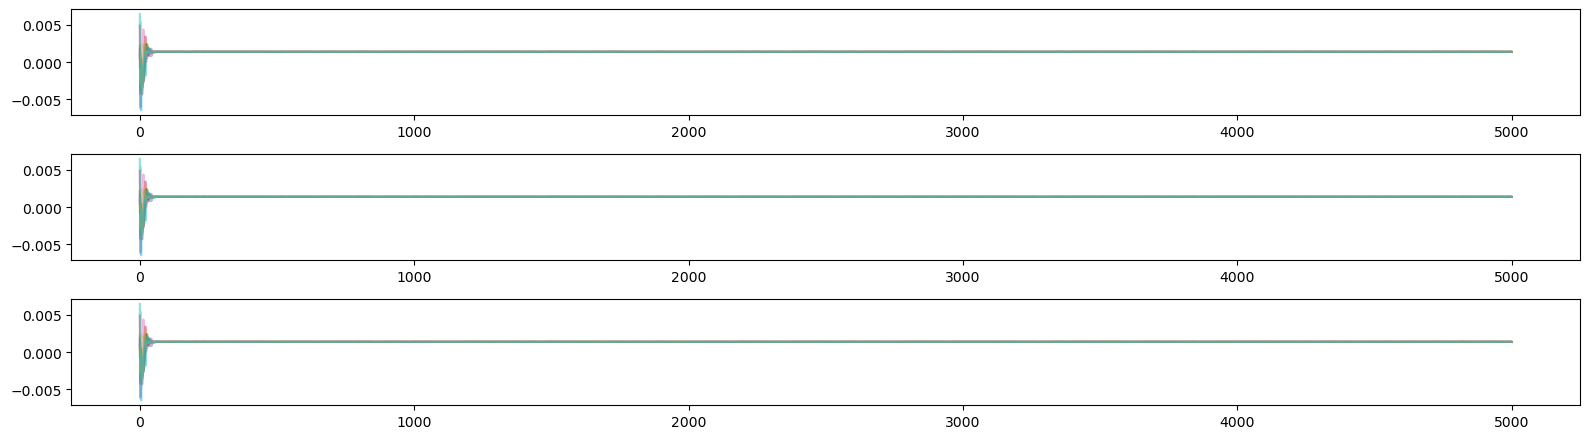

In [412]:
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,0], alpha=0.5)
plt.tight_layout()
plt.show()

/home/holman/miniconda3/envs/cosmos/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/holman/miniconda3/envs/cosmos/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/holman/miniconda3/envs/cosmos/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/holman/miniconda3/envs/cosmos/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/holman/miniconda3/envs/cosmos/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/holman/miniconda3/envs/cosmos/lib/pytho

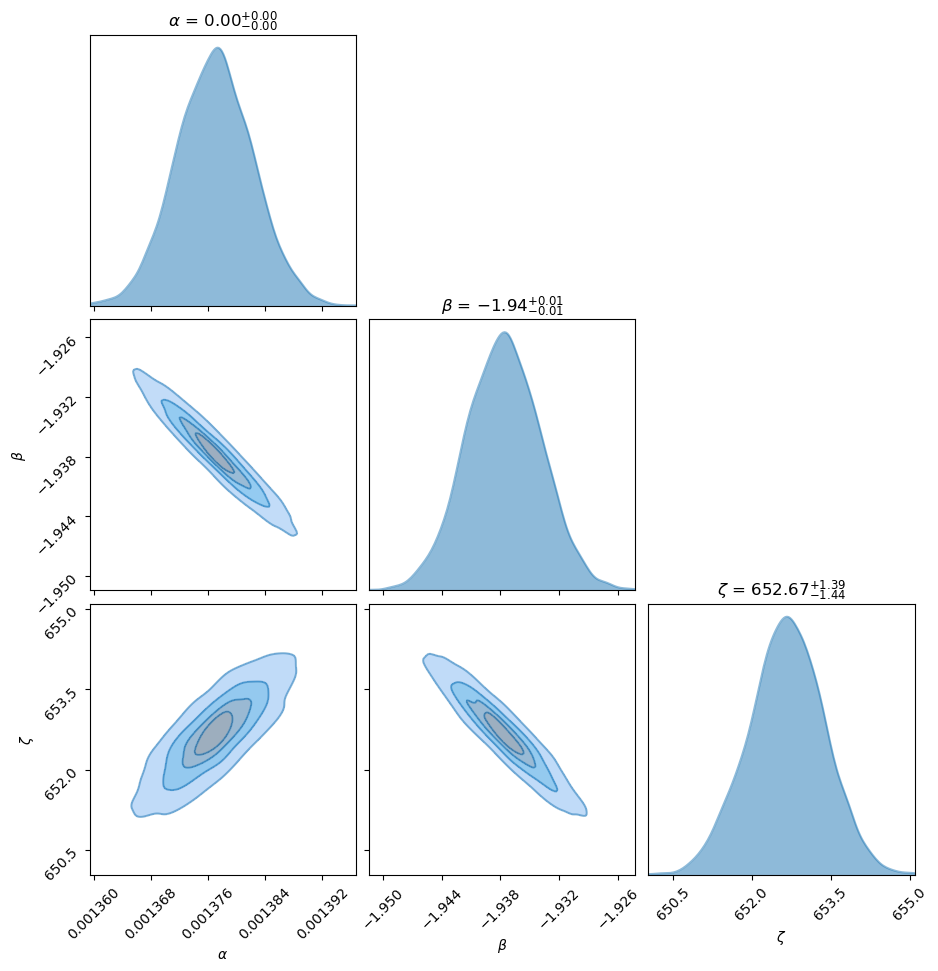

In [413]:
# flatten the chains, thin them by a factor of 10, and remove the burn-in (first half of the chain)
chain = sampler.get_chain(flat=True, discard=1000, thin=10)

# plot marginal posterior distributions
fig, axes = zeus.cornerplot(chain, labels=[r'$\alpha$',r'$\beta$',r'$\zeta$']);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


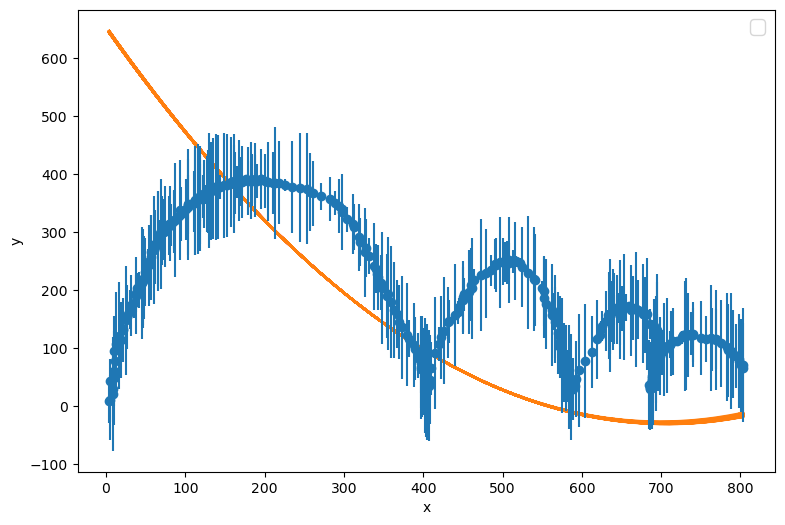

In [414]:
inds = np.random.randint(len(chain), size=1000)
plt.figure(figsize=(9,6))
for ind in inds:
    sample = chain[ind]
    plt.plot(W['x'], np.dot(np.vander(W['x'], 3), sample[:3]), "C1", alpha=0.6)
plt.errorbar(W['x'], W['y'], yerr=W['sigma'], fmt="o")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");

In [415]:
labels=['alpha','beta','zeta']
for i in range(ndim):
    mcmc = np.percentile(chain[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Funcion sinusoidal

$$f(x)  = e^{-\gamma x} A  \text{cos}(\omega x + \phi) + \zeta$$

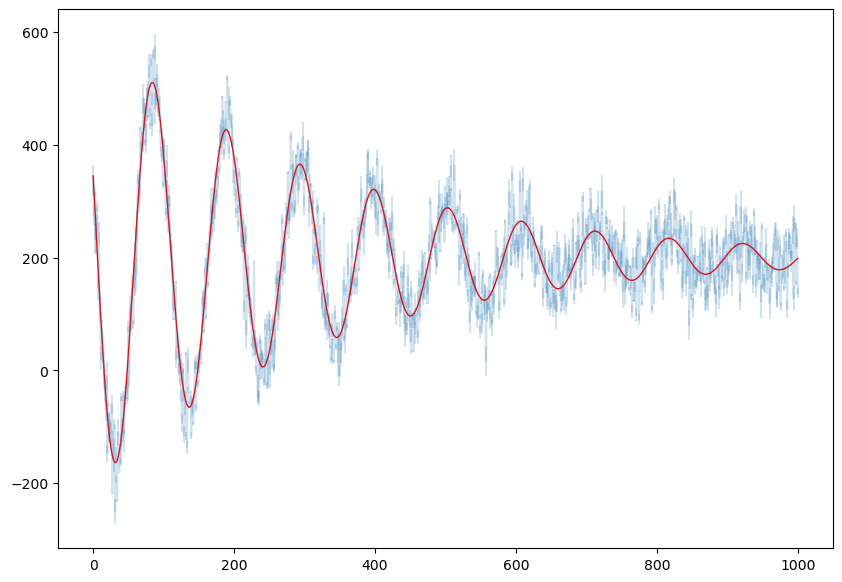

In [ ]:
# define the model function
def sinusoidal(x, gamma, A, omega, phi, zeta):
    ''' Parabola: y = Asen(Bx+C) + D '''
    EXP = np.exp(-1*gamma*x)
    COS = np.cos(omega*x + phi)

    result = EXP * A * COS + zeta

    return result


X = np.linspace(0,1000,1000)
Y = sinusoidal(X,0.003,400,0.06,1.2,200)
Y_sin = Y + np.random.normal(0, 40,size = len(Y))
Y_error = np.random.uniform(0, 30, size=len(Y))

plt.figure(figsize=(10,7))

plt.errorbar(X,Y_sin,yerr=Y_error, alpha=0.2)
plt.plot(X,Y,color ='red',linewidth = 1)

In [ ]:
def logprior(theta):
    ''' The natural logarithm of the prior probability. '''
    lp = 0.
    # unpack the model parameters from the tuple
    gamma, A, omega, phi, zeta = theta

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    if (0 < gamma < 0.01) or (-500 < A < 500) or (0 < omega < 0.1) or (-np.pi < phi < np.pi) or (0 < zeta < 1000):
        return lp
    else:
        return -np.inf


def loglike(theta, y, sigma, x):
    '''The natural logarithm of the likelihood.'''

    # unpack the model parameters
    gamma, A, omega, phi, zeta = theta

    # evaluate the model
    model = sinusoidal(x, gamma, A, omega, phi, zeta)

    # return the log likelihood
    return -0.5 * np.sum(((model - y)/sigma)**2)

def logpost(theta, y, sigma, x):
    '''The natural logarithm of the posterior.'''

    return logprior(theta) + loglike(theta, y, sigma, x)

In [418]:
ndim = 5 # Number of parameters/dimensions (e.g. m and c)
nwalkers = 12 # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 3000 # Number of steps/iterations.

start = 0.01 * np.random.randn(nwalkers, ndim) # Initial positions of the walkers.

sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, args=[Y_sin,Y_error, X]) # Initialise the sampler
sampler.run_mcmc(start, nsteps) # Run sampling
sampler.summary # Print summary diagnostics

Initialising ensemble of 12 walkers...
Sampling progress :   0%|          | 0/3000 [00:00<?, ?it/s]/tmp/ipykernel_15083/269430411.py:4: RuntimeWarning: overflow encountered in exp
  EXP = np.exp(-1*gamma*x)
/tmp/ipykernel_15083/625606175.py:24: RuntimeWarning: overflow encountered in square
  return -0.5 * np.sum(((model - y)/sigma)**2)
/tmp/ipykernel_15083/269430411.py:7: RuntimeWarning: overflow encountered in multiply
  result = EXP * A * COS + zeta
/tmp/ipykernel_15083/625606175.py:24: RuntimeWarning: overflow encountered in divide
  return -0.5 * np.sum(((model - y)/sigma)**2)
Sampling progress :   6%|▌         | 166/3000 [00:05<01:12, 39.14it/s]

KeyboardInterrupt: 

Sampling progress :   6%|▌         | 168/3000 [00:21<01:12, 39.14it/s]

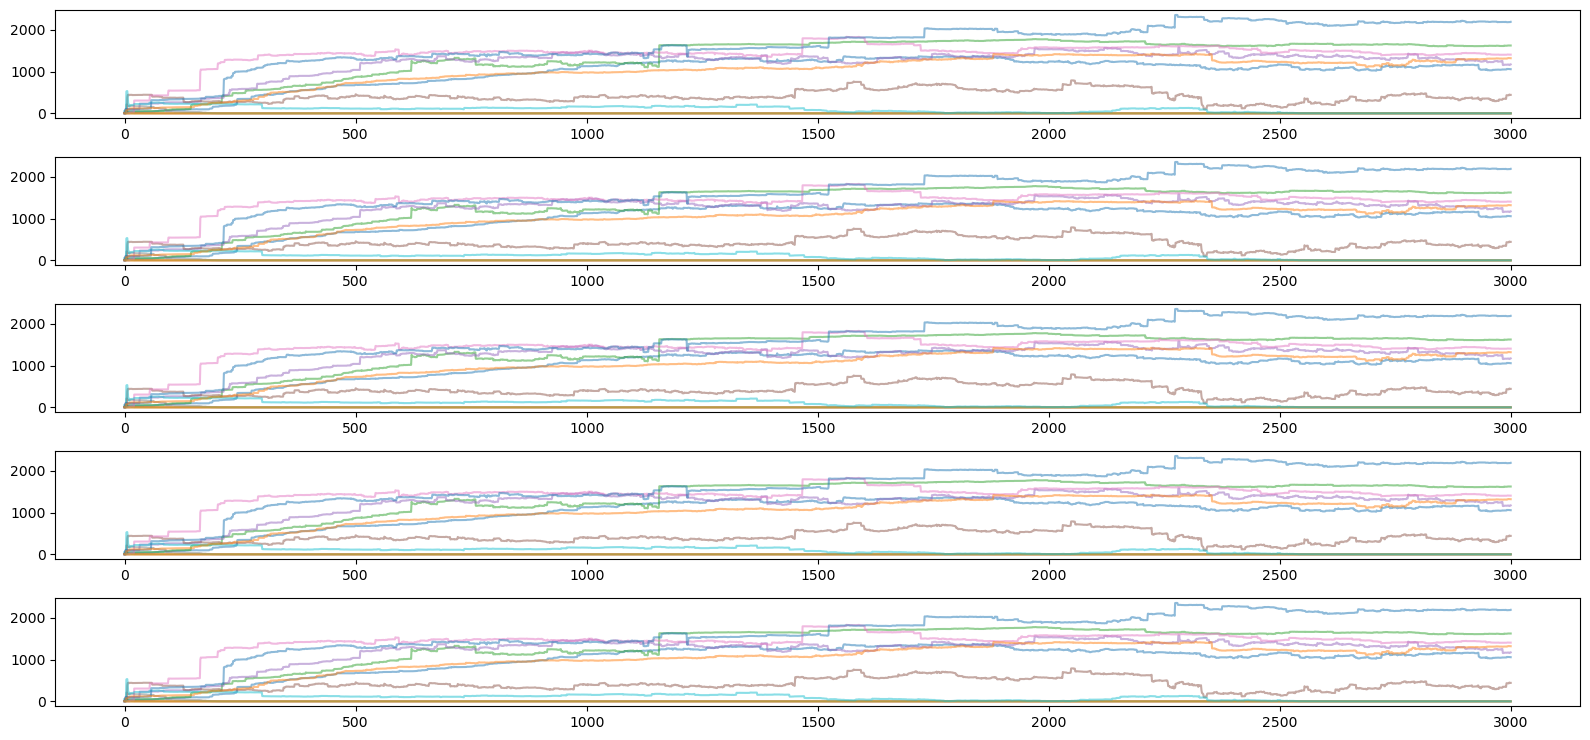

In [ ]:
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,0], alpha=0.5)
plt.tight_layout()
plt.show()

/home/holman/miniconda3/envs/cosmos/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/holman/miniconda3/envs/cosmos/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/holman/miniconda3/envs/cosmos/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/holman/miniconda3/envs/cosmos/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/holman/miniconda3/envs/cosmos/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/holman/miniconda3/envs/cosmos/lib/pytho

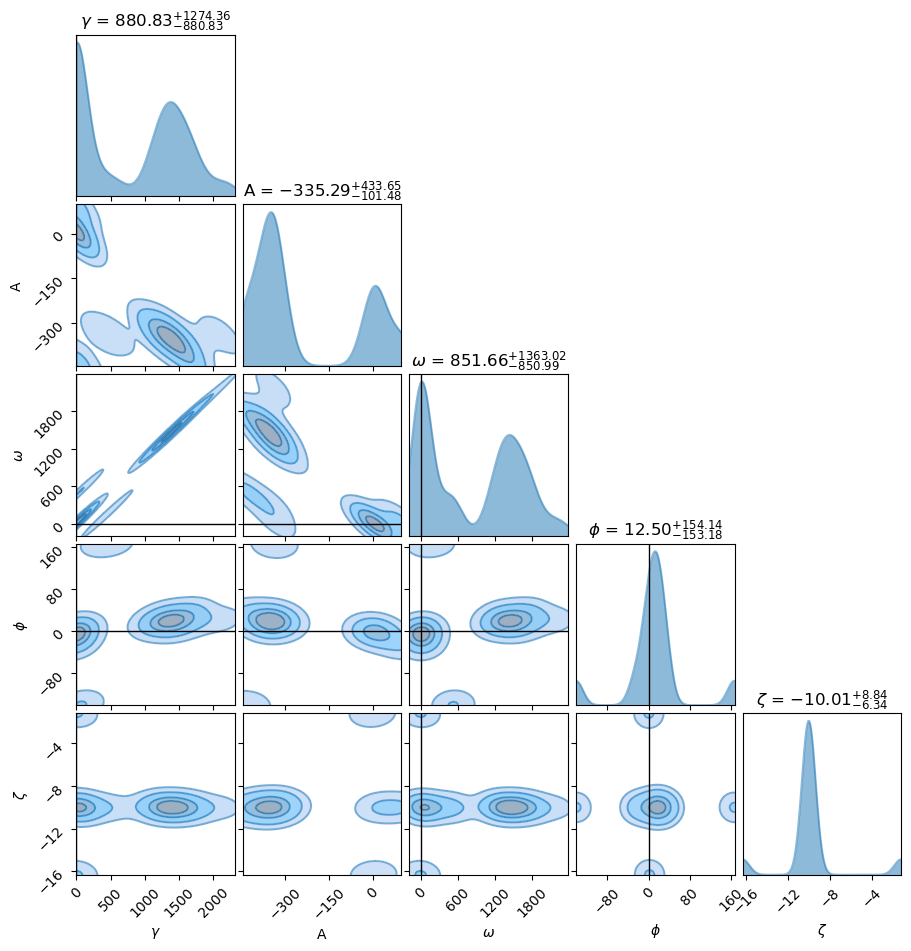

In [ ]:
# flatten the chains, thin them by a factor of 10, and remove the burn-in (first half of the chain)
chain = sampler.get_chain(flat=True, discard=1000, thin=10)

# plot marginal posterior distributions
fig, axes = zeus.cornerplot(chain, labels=[r'$\gamma$',r'A',r'$\omega$',r'$\phi$',r'$\zeta$'],
                            truth = [0.003,400,0.06,1.2,200]);

Sampling progress :  10%|█         | 105/1000 [05:56<50:38,  3.40s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


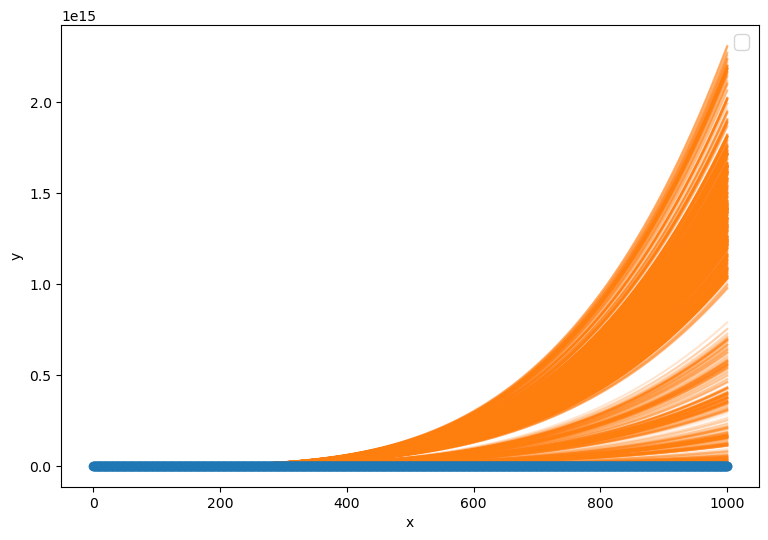

In [ ]:
inds = np.random.randint(len(chain), size=5000)
plt.figure(figsize=(9,6))
for ind in inds:
    sample = chain[ind]
    plt.plot(X, np.dot(np.vander(X, 5), sample[:5]), "C1", alpha=0.1)
plt.errorbar(X, Y_sin, yerr=Y_error, fmt="o")
plt.legend(fontsize=14)
#plt.ylim(0,0.5)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
labels=['alpha','beta','phi','zeta']
for i in range(ndim):
    mcmc = np.percentile(chain[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

IndexError: list index out of range

## Funcion modelo de Milankovitch

$$\Delta T  = a_1 \text{sen}  \Bigg( \frac{2\pi t}{p_1} \Bigg)  + a_2 \text{sen}  \Bigg( \frac{2\pi t}{p_2} \Bigg)  + a_3 \text{sen}  \Bigg( \frac{2\pi t}{p_3} \Bigg)   + T_0$$

In [ ]:
def model(theta,age=age):
    a1,a2,a3,p1,p2,p3,T0 = theta
    model = #your code here
    return model